In [25]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import scipy.stats
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

import activity_classifier_utils

In [26]:
fs = 256
data = activity_classifier_utils.LoadWristPPGDataset()
labels, subjects, features = activity_classifier_utils.GenerateFeatures(data,
                                                                        fs,
                                                                        window_length_s=10,
                                                                        window_shift_s=10)

In [27]:
n_estimators_opt = [2, 10, 20, 50, 100, 150, 300]
max_tree_depth_opt = range(2, 7)
class_names = np.array(['bike', 'run', 'walk'])
logo = LeaveOneGroupOut()
accuracy_table = []

In [19]:
import itertools

for n_estimators, max_tree_depth in itertools.product(n_estimators_opt, max_tree_depth_opt):
    # Iterate over each pair of hyperparameters
    cm = np.zeros((3, 3), dtype='int')                       # Create a new confusion matrix
    clf = RandomForestClassifier(n_estimators=n_estimators,  # and a new classifier  for each
                                 max_depth=max_tree_depth,   # pair of hyperparameters
                                 random_state=42,
                                 class_weight = "balanced"
                                )
    for train_ind, test_ind in logo.split(features, labels, subjects):
        # Do leave-one-subject-out cross validation as before.
        X_train, y_train = features[train_ind], labels[train_ind]
        X_test, y_test = features[test_ind], labels[test_ind]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        c = confusion_matrix(y_test, y_pred, labels=class_names)
        cm += c
    # For each pair of hyperparameters, compute the classification accuracy
    classification_accuracy = np.sum(np.diag(cm)) / np.sum(np.sum(cm))
    
    # Store the hyperparameters and the classification accuracy that resulted
    # from the model created with them.
    accuracy_table.append((n_estimators, max_tree_depth, classification_accuracy))

In [20]:
accuracy_table_df = pd.DataFrame(accuracy_table,
                                 columns=['n_estimators', 'max_tree_depth', 'accuracy'])
accuracy_table_df.head()

,n_estimators,max_tree_depth,accuracy
0,2,2,0.648118
1,2,3,0.646481
2,2,4,0.612111
3,2,5,0.657938
4,2,6,0.631751


In [21]:
accuracy_table_df.loc[accuracy_table_df.accuracy.idxmax()]

n_estimators      10.000000
max_tree_depth     2.000000
accuracy           0.746318
Name: 5, dtype: float64

In [7]:
class_names = ['bike', 'run', 'walk']

# Store the confusion matrix for the outer CV fold.
nested_cv_cm = np.zeros((3, 3), dtype='int')
splits = 0

for train_val_ind, test_ind in logo.split(features, labels, subjects):
    # Split the dataset into a test set and a training + validation set.
    # Model parameters (the random forest tree nodes) will be trained on the training set.
    # Hyperparameters (how many trees and the max depth) will be trained on the validation set.
    # Generalization error will be computed on the test set.
    X_train_val, y_train_val = features[train_val_ind], labels[train_val_ind]
    subjects_train_val = subjects[train_val_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    
    # Keep track of the best hyperparameters for this training + validation set.
    best_hyper_parames = None
    best_accuracy = 0
    
    for n_estimators, max_tree_depth in itertools.product(n_estimators_opt,
                                                          max_tree_depth_opt):
        # Optimize hyperparameters as above.
        inner_cm = np.zeros((3, 3), dtype='int')
        clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_tree_depth,
                                     random_state=42,
                                     class_weight='balanced')
        for train_ind, validation_ind in logo.split(X_train_val, y_train_val,
                                                    subjects_train_val):
            X_train, y_train = X_train_val[train_ind], y_train_val[train_ind]
            X_val, y_val = X_train_val[validation_ind], y_train_val[validation_ind]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            c = confusion_matrix(y_val, y_pred, labels=class_names)
            inner_cm += c
        classification_accuracy = np.sum(np.diag(inner_cm)) / np.sum(np.sum((inner_cm)))
        
        # Keep track of the best pair of hyperparameters.
        if classification_accuracy > best_accuracy:
            best_accuracy = classification_accuracy
            best_hyper_params = (n_estimators, max_tree_depth)
    
    # Create a model with the best pair of hyperparameters for this training + validation set.
    best_clf = RandomForestClassifier(n_estimators=best_hyper_params[0],
                                      max_depth=best_hyper_params[1],
                                      class_weight='balanced')
    
    # Finally, train this model and test it on the test set.
    best_clf.fit(X_train_val, y_train_val)
    y_pred = best_clf.predict(X_test)
    
    # Aggregate confusion matrices for each CV fold.
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    nested_cv_cm += c
    splits += 1
    print('Done split {}'.format(splits))


Done split 1
Done split 2
Done split 3
Done split 4
Done split 5
Done split 6
Done split 7
Done split 8


In [8]:
np.sum(np.diag(nested_cv_cm)) / np.sum(np.sum(nested_cv_cm))

0.6677577741407529

In [9]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=4,
                             random_state=42,
                             class_weight='balanced')
activity_classifier_utils.LOSOCVPerformance(features, labels, subjects, clf)
feat = clf.feature_importances_
print(len(feat))

55


<BarContainer object of 55 artists>

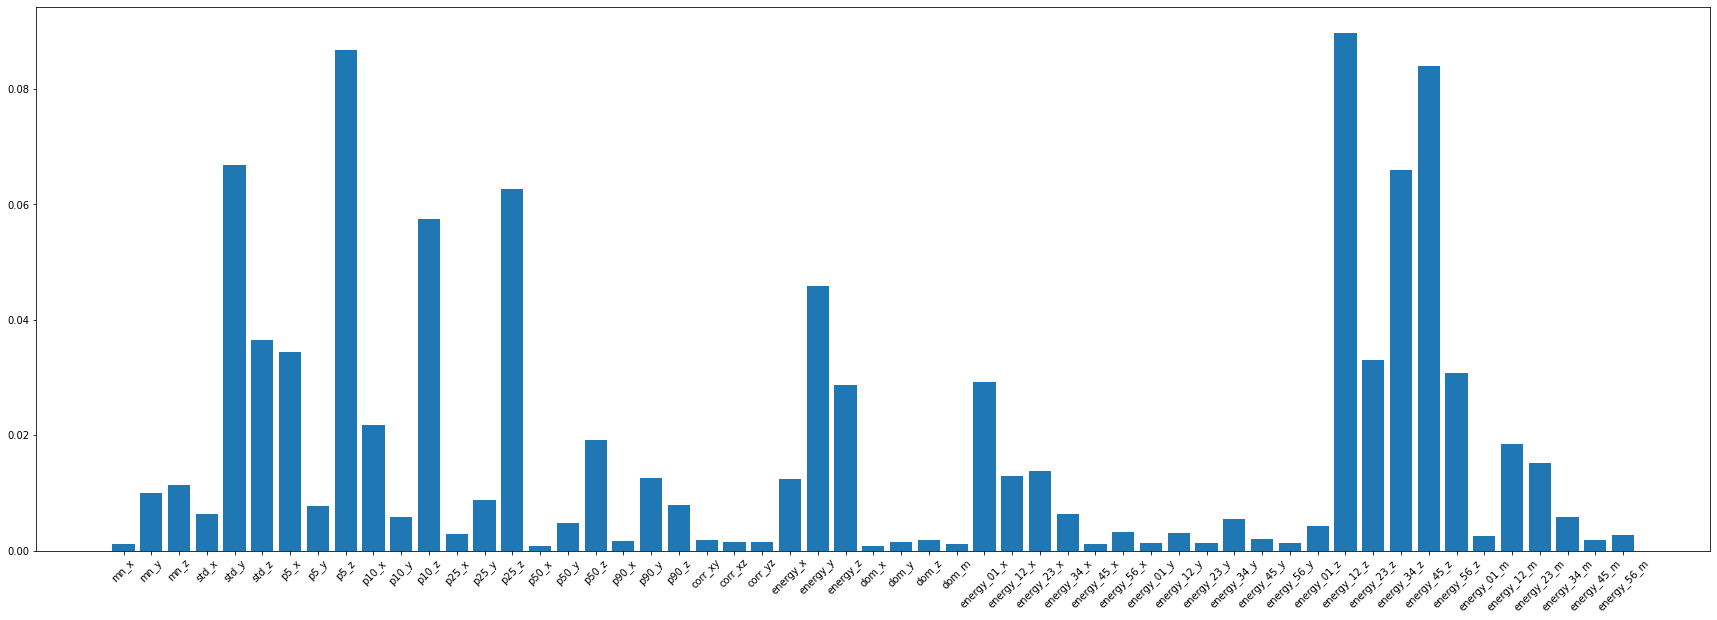

In [10]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=45)
plt.bar(x =activity_classifier_utils.FeatureNames(), height= feat)

In [11]:
 sorted(list(zip(clf.feature_importances_, activity_classifier_utils.FeatureNames())), reverse=True)[:10]


[(0.08974367031248157, 'energy_12_z'),
 (0.08671662576814966, 'p5_z'),
 (0.08400576038467573, 'energy_45_z'),
 (0.06682182257645457, 'std_y'),
 (0.06595043421828506, 'energy_34_z'),
 (0.06261544620382087, 'p25_z'),
 (0.05745142469573473, 'p10_z'),
 (0.04590935737028491, 'energy_y'),
 (0.036432851448179565, 'std_z'),
 (0.03448801783830703, 'p5_x')]

In [12]:
sorted_features = sorted(zip(clf.feature_importances_, np.arange(len(clf.feature_importances_))), reverse=True)
best_feature_indices = list(zip(*sorted_features))[1]
X = features[:, best_feature_indices[:10]]

In [13]:
X.shape

(611, 10)

Normalized confusion matrix
[[0.93877551 0.06122449 0.        ]
 [0.05022831 0.87671233 0.07305936]
 [0.01360544 0.03401361 0.95238095]]
Classification accuracy = 0.92


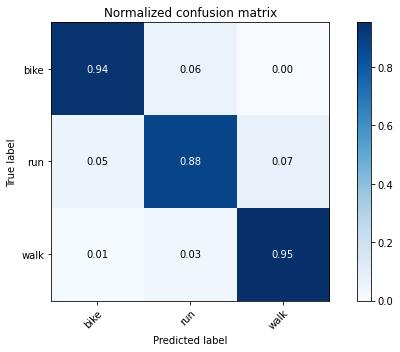

In [14]:
cm = activity_classifier_utils.LOSOCVPerformance(X, labels, subjects, clf)
activity_classifier_utils.PlotConfusionMatrix(cm, class_names, normalize=True)
print('Classification accuracy = {:0.2f}'.format(np.sum(np.diag(cm)) / np.sum(np.sum(cm))))

In [29]:
!python train.py

   n_estimators  ...  accuracy
0             2  ...  0.787234
1             2  ...  0.605565
2             2  ...  0.687398
3             2  ...  0.657938
4             2  ...  0.808511

[5 rows x 3 columns]
